#Site-adaptation

El diseño y la puesta en marcha de **soluciones fotovoltaicas eficientes** en un lugar concreto requieren una **caracterización precisa** de la energía solar disponible en la región de interés. Por lo tanto, se necesitan **datos históricos fiables** de la irradiación solar para comprender la variabilidad espacial y temporal a largo plazo del recurso solar. 

**Mediciones satelitales**: alta resolución temporal pero resolución espacial limitada.

**Mediciones in situ**: alta precisión pero con falta de datos.

**Objetivo**: tomar lo mejor de ambas fuentes de datos para obtener una resolución espacio-temporal mejorada, conocida como site-adaptation.




##Datos IDEAM

Datos correspondientes de irradiación solar (W/m^2) a la estación: BOTANA - AUT [52055210]. 

Desde 2006 hasta 2017 con mediciones cada hora. 22% de datos faltantes.

http://dhime.ideam.gov.co/atencionciudadano/

![IDEAM](https://drive.google.com/uc?export=view&id=1xjlD1ZZfuKa5KMiXtFRkBMuR-4f9pwLr)

##Datos NREL

Datos satelitales correspondientes de irradiación solar (global, directa, difusa) (W/m^2), temperatura (°C), velocidad de viento (m/s), y ángulo solar Zenith. Con mediciones desde 1998 hasta 2017 con mediciones cada 30 minutos y resolución espacial de 4 km^2. The National Solar Radiation Database.
https://maps.nrel.gov/nsrdb-viewer

![time_line](https://drive.google.com/uc?export=view&id=1Q0QG-ODIvrf8fBg5gPi84BDW23Vu7lYy)

#Metodología: Site-adpatition

![site_adaptation](https://drive.google.com/uc?export=view&id=1KWzplb4m7ZO2VQEsoVhrUnIaxZSt3812)

#La preparación de los datos representa alrededor del **80% del trabajo**

![pie_chart](https://drive.google.com/uc?export=view&id=18c7n7w7vm1Pvcu-EWAxkh8uwx6WKJ0c_)

https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/?sh=2b27a0ef6f63


#Secciones

[1. Importar librerías](#import_librerias)

[2. Cargar bases de datos](#cargar_imagenes)

[3. Modelos de regresión](#modelos)

[4. Probando mejor modelo en conjunto de prueba](#test)

[5. Guardar mejor modelo](#guardar_modelo)

[6. Pruebas del mejor modelo](#pruebas)

[7. Aplicar el modelo a toda la base de datos satelital](#aplicar_modelo)

[8. Guardar base de datos mejorada](#base_datos_final)

[9. Retos](#retos)

<a name="import_librerias"></a>
#1. Importar librerías

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

<a name="cargar_imagenes"></a>
#2. Cargar bases de datos

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ML in PV systems/Site-Adaptation/data_IDEAM_NREL.csv')
data.head(24)

,Fecha,GHI_IDEAM,GHI_NSRDB,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
0,2006-01-01 00:00:00,0,0,0,0,0,7,157
1,2006-01-01 01:00:00,0,0,0,0,0,7,153
2,2006-01-01 02:00:00,0,0,0,0,0,6,142
3,2006-01-01 03:00:00,0,0,0,0,0,6,130
4,2006-01-01 04:00:00,0,0,0,0,0,6,117
5,2006-01-01 05:00:00,0,0,0,0,0,6,103
6,2006-01-01 06:00:00,0,21,11,160,0,6,89
7,2006-01-01 07:00:00,513,219,48,695,1,8,76
8,2006-01-01 08:00:00,1633,480,64,901,1,10,62
9,2006-01-01 09:00:00,1290,368,319,78,1,12,49


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81579 entries, 0 to 81578
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Fecha               81579 non-null  object
 1   GHI_IDEAM           81579 non-null  int64 
 2   GHI_NSRDB           81579 non-null  int64 
 3   DHI                 81579 non-null  int64 
 4   DNI                 81579 non-null  int64 
 5   Wind Speed          81579 non-null  int64 
 6   Temperature         81579 non-null  int64 
 7   Solar Zenith Angle  81579 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 5.0+ MB


###2.1 Comparar IDEAM vs NSRDB

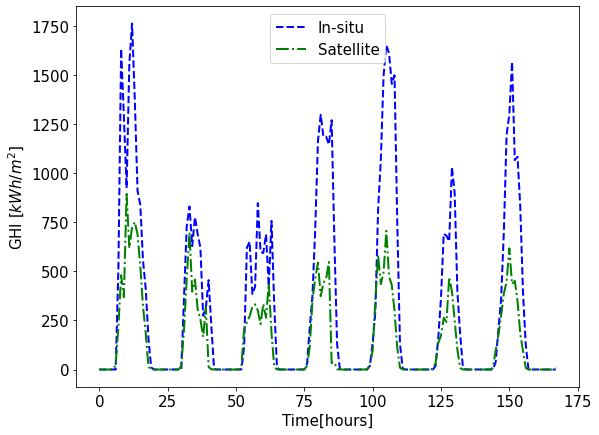

In [ ]:
ghi_ideam = data['GHI_IDEAM'].values
ghi_nsrdb = data['GHI_NSRDB'].values

plt.figure()
plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(ghi_ideam[0:24*7],'--b', label='In-situ', linewidth=2)
plt.plot(ghi_nsrdb[0:24*7],'-.g', label='Satellite', linewidth=2)
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=15)
plt.yticks(size=15)
# plt.savefig('/figure.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
data.corr(method ='pearson')

,GHI_IDEAM,GHI_NSRDB,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
GHI_IDEAM,1.000000,0.808026,0.735807,0.464808,0.260595,0.718470,-0.707808
GHI_NSRDB,0.808026,1.000000,0.832601,0.633091,0.300985,0.741691,-0.737313
DHI,0.735807,0.832601,1.000000,0.168045,0.376760,0.776653,-0.793081
DNI,0.464808,0.633091,0.168045,1.000000,0.052352,0.290528,-0.303762
Wind Speed,0.260595,0.300985,0.376760,0.052352,1.000000,0.421137,-0.526637
Temperature,0.718470,0.741691,0.776653,0.290528,0.421137,1.000000,-0.830112
Solar Zenith Angle,-0.707808,-0.737313,-0.793081,-0.303762,-0.526637,-0.830112,1.000000


###2.2 Agregar la **hora** como variable de entrada

In [ ]:
hora = []
for i in range(len(data['Fecha'])):
    var = data['Fecha'][i][11:13]
    hora.append(var)
data = data.drop(columns='Fecha')
data = pd.DataFrame(np.column_stack((hora,data)))
data = data.rename(columns={0: 'Hora', 1: 'GHI_IDEAM', 2: 'GHI_NSRDB', 3: 'DHI', 4: 'DNI', 
                                                 5: 'Wind Speed', 6: 'Temperature', 7: 'Solar Zenith Angle'})
data.head(24)

,Hora,GHI_IDEAM,GHI_NSRDB,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
0,00,0,0,0,0,0,7,157
1,01,0,0,0,0,0,7,153
2,02,0,0,0,0,0,6,142
3,03,0,0,0,0,0,6,130
4,04,0,0,0,0,0,6,117
5,05,0,0,0,0,0,6,103
6,06,0,21,11,160,0,6,89
7,07,513,219,48,695,1,8,76
8,08,1633,480,64,901,1,10,62
9,09,1290,368,319,78,1,12,49


###2.3 Modelo de Site-adaptation 

![site_adaptation_model](https://drive.google.com/uc?export=view&id=1T2tdbF3isESxpNG67seshObqU9iMP_E4)

<a name="modelos"></a>
#3. Modelos de regresión

###3.1 Mezclar los datos

In [ ]:
from sklearn.utils import shuffle
X_ = data[['Hora','GHI_NSRDB','DHI','DNI','Wind Speed','Temperature','Solar Zenith Angle']]
y_ = data['GHI_IDEAM']
X, y = shuffle(X_, y_, random_state=42)

In [ ]:
X.head(10)

,Hora,GHI_NSRDB,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
8971,03,0,0,0,1,7,129
15889,04,0,0,0,0,5,115
45059,16,177,164,24,3,9,62
65352,16,132,130,6,4,10,63
62415,12,1086,144,963,1,13,12
36552,14,198,186,15,3,10,37
26800,11,291,270,20,2,14,16
24184,10,162,150,12,3,15,26
72488,14,785,225,732,3,13,40
66534,03,0,0,0,0,6,128


###3.2 Escalar y dividir en entrenamiento, prueba y validación

In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()

n = len(X)
X_train = X[:round(n*.7)] # 70% de los datos va a ser utilizado para el entrenamiento
X_valid = X[round(n*.7):round(n*.85)] # 15% de los datos va ser utilizado para validación
X_test = X[round(n*.85):] # 15% de los datos va a ser utilizado para testing

X_train = X_scaler.fit_transform(X_train)
X_valid = X_scaler.transform(X_valid)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()

y = y.values.reshape(-1, 1)
y_train = y[:round(n*.7)]
y_valid = y[round(n*.7):round(n*.85)]
y_test = y[round(n*.85):]

y_train = y_scaler.fit_transform(y_train).ravel()
y_valid = y_scaler.transform(y_valid).ravel()
y_test = y_scaler.transform(y_test).ravel()

##3.3 Regresión Lineal

In [ ]:
lin_reg = LinearRegression()

lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print('Root mean square error: ', round(rmse,2))
print('Mean absolute error: ', round(mae,2))
print('R-Squared: ', round(r2,2))

Root mean square error:  0.56
Mean absolute error:  0.35
R-Squared:  0.7


##3.4 Random Forest

Es un modelo basado en árboles de decisión que se construyen en paralelo usando subconjuntos aleatorios de variables de entrada. Una vez que se entrenan los árboles de decisión, un modelo de RF toma un ejemplo, lo pasa por todos los árboles y asigna la clase con la mayor cantidad de votos o asigna un número si es de tipo regressor.

![random_forest](https://drive.google.com/uc?export=view&id=10UatLP5QQJb35d35hXJF_mAEtwf8VVjM)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=200,random_state=42)
forest_reg.fit(X_train,y_train)
y_pred = forest_reg.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print('Root mean square error: ', round(rmse,2))
print('Mean absolute error: ', round(mae,2))
print('R-Squared: ', round(r2,2))

Root mean square error:  0.53
Mean absolute error:  0.27
R-Squared:  0.73


###3.4.1 Feature importance

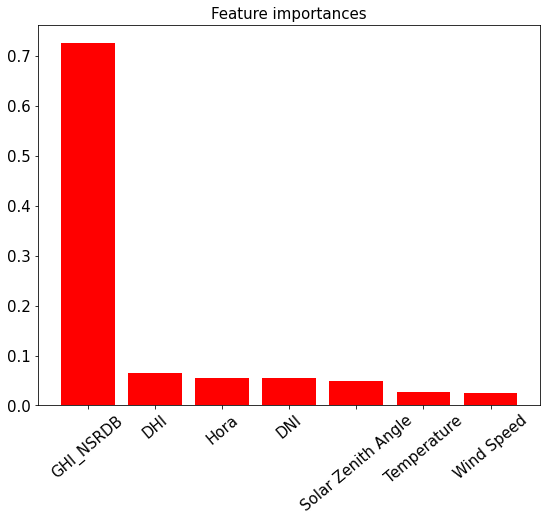

In [ ]:
importances = forest_reg.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_.columns

plt.figure()
plt.title("Feature importances", size=15)
plt.bar(range(X_.shape[1]), importances[indices],
       color="r", align="center")                   
plt.xticks(range(X_.shape[1]), features[indices], rotation=40, size=15)
plt.yticks(size=15)
# plt.savefig('feat_impo.png', format='png', dpi=300)
plt.show()


##3.5 Redes Neuronales


son modelos que están inspirados en las interconexiones neuronales del cerebro como unidades de procesamiento. Una red neuronal define una función que mapea una entrada $n$-dimensional a una salida $r$-dimensional, y que se construye como la interconexión en paralelo y en serie de unidades de procesamiento básicas, llamadas neuronas. Cada neurona calcula una suma ponderada de sus propias entradas que luego se transforma utilizando una función conocida como función de activación. El proceso de aprendizaje se refiere al proceso de encontrar los pesos para cada neurona de manera que el modelo de red neuronal pueda predecir con precisión la salida para una entrada dada.

![mlp](https://drive.google.com/uc?export=view&id=14tZjR5NcCfYNN6bmXB3sePAeSB5oYfiu)

In [ ]:
rn_reg = MLPRegressor(hidden_layer_sizes=[10], activation='relu', random_state=42, max_iter=500)
rn_reg.fit(X_train, y_train)
y_pred = rn_reg.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print('Root mean square error: ', round(rmse,2))
print('Mean absolute error: ', round(mae,2))
print('R-Squared: ', round(r2,2))

Root mean square error:  0.52
Mean absolute error:  0.27
R-Squared:  0.74


<a name="test"></a>
#4 Probando mejor modelo en conjunto de prueba

In [ ]:
y_pred = rn_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Root mean square error: ', round(rmse,2))
print('Mean absolute error: ', round(mae,2))
print('R-Squared: ', round(r2,2))

Root mean square error:  0.52
Mean absolute error:  0.26
R-Squared:  0.74


<a name="guardar_modelo"></a>
#5 Guardar mejor modelo

In [ ]:
import joblib
joblib.dump(rn_reg, '/content/drive/MyDrive/ML in PV systems/Site-Adaptation/mejor_modelo.pkl')

['/content/drive/MyDrive/ML in PV systems/Site-Adaptation/mejor_modelo.pkl']

<a name="pruebas"></a>
#6 Pruebas del mejor modelo

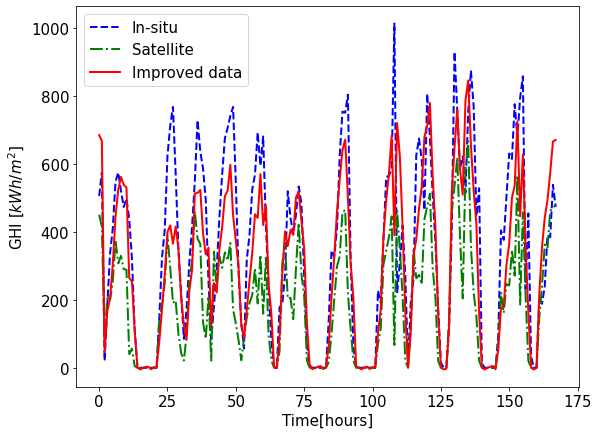

In [ ]:
X_norm = X_scaler.fit_transform(X_)
predictions = rn_reg.predict(X_norm)
y_pred = y_scaler.inverse_transform(predictions.reshape(-1,1))

start = 10000


plt.figure()
plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(ghi_ideam[start+24*7:start+24*2*7],'--b', label='In-situ', linewidth=2)
plt.plot(ghi_nsrdb[start+24*7:start+24*2*7],'-.g', label='Satellite', linewidth=2)
plt.plot(y_pred[start+24*7:start+24*2*7],'r', label='Improved data', linewidth=2)
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=15)
plt.yticks(size=15)
# plt.savefig('/figure.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
data_improved = pd.DataFrame({"GHI_IDEAM": ghi_ideam, "GHI_NSRDB": ghi_nsrdb, "GHI_improved": y_pred.reshape(-1)})
data_improved.corr(method ='pearson')

,GHI_IDEAM,GHI_NSRDB,GHI_improved
GHI_IDEAM,1.000000,0.808026,0.862362
GHI_NSRDB,0.808026,1.000000,0.934408
GHI_improved,0.862362,0.934408,1.000000


<a name="aplicar_modelo"></a>
#7 Aplicar el modelo a toda la base de datos satelital

In [ ]:
data_NREL = pd.read_csv('/content/drive/MyDrive/ML in PV systems/Site-Adaptation/data_NREL.csv')
data_NREL.head()

,Date,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
0,1998-01-01 00:00:00,1998,1,1,0,0,0,0,0,0.9,8,157.61
1,1998-01-01 00:30:00,1998,1,1,0,30,0,0,0,0.8,7,157.44
2,1998-01-01 01:00:00,1998,1,1,1,0,0,0,0,0.7,7,155.06
3,1998-01-01 01:30:00,1998,1,1,1,30,0,0,0,0.7,7,150.99
4,1998-01-01 02:00:00,1998,1,1,2,0,0,0,0,0.7,7,145.84


In [ ]:
data_NREL = data_NREL[['Hour','GHI','DHI','DNI','Wind Speed','Temperature','Solar Zenith Angle']]
data_NREL.head()

,Hour,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
0,0,0,0,0,0.9,8,157.61
1,0,0,0,0,0.8,7,157.44
2,1,0,0,0,0.7,7,155.06
3,1,0,0,0,0.7,7,150.99
4,2,0,0,0,0.7,7,145.84


In [ ]:
var = data_NREL[['GHI','DHI','DNI','Wind Speed','Temperature','Solar Zenith Angle']]
data_NREL_prom = []
for i in tqdm(range(0,len(data_NREL),2)):
    data_NREL_prom.append(np.array((var.iloc[i] + var.iloc[i+1])/2))

hora = []
for i in tqdm(range(0,len(data_NREL),2)):
    hora.append(data_NREL['Hour'][i])

data_NREL_prom = np.column_stack((hora,data_NREL_prom))
data_NREL_prom = pd.DataFrame(data_NREL_prom)
data_NREL_prom = data_NREL_prom.rename(columns={0:'Hour',1:'GHI',2:'DHI',3:'DNI',4:'Wind Speed',5:'Temperature',6:'Solar Zenith Angle'})

100%|██████████| 175200/175200 [00:01<00:00, 143453.82it/s]


In [ ]:
data_NREL_prom.head()

,Hour,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
0,0.0,0.0,0.0,0.0,0.85,7.5,157.525
1,1.0,0.0,0.0,0.0,0.70,7.0,153.025
2,2.0,0.0,0.0,0.0,0.70,6.5,142.935
3,3.0,0.0,0.0,0.0,0.70,6.0,130.575
4,4.0,0.0,0.0,0.0,0.70,6.0,117.310


In [ ]:
scaler = StandardScaler()
data_NREL_norm = X_scaler.fit_transform(data_NREL_prom)

data_impr = forest_reg.predict(data_NREL_norm)
data_impr = y_scaler.inverse_transform(data_impr.reshape(-1,1))

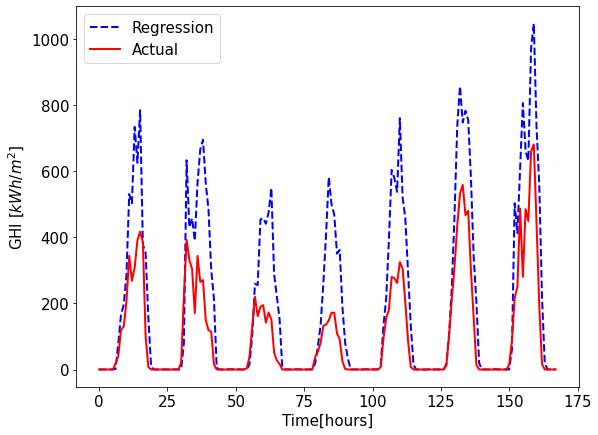

In [ ]:
plt.plot(data_impr[:24*7],'b--', label='Regression', linewidth=2)
plt.plot(data_NREL_prom['GHI'][:24*7],'r', label='Actual', linewidth=2)
plt.legend()
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=15)
plt.yticks(size=15)
plt.show()

<a name="base_datos_final"></a>
#8 Guardar base de datos mejorada

In [ ]:
GHI_impr = pd.DataFrame(np.round(data_impr))
GHI_impr.to_csv('/content/drive/MyDrive/Colab Notebooks/ML in PV systems/Site-Adaptation/GHI_impr.csv', index=False)

<a name="retos"></a>
#9. Retos

1. Probar otros métodos de regresión como Support Vector Regression, AdaBoost.
2. Implementar validación cruzada (cross-validation).
3. Probar otras arquitecturas para la red neuronal.

Hint:

from sklearn.svm import SVR

from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score

https://www.sciencedirect.com/science/article/abs/pii/S0960148120318395

